In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# The Mauna Loa CO2 concentration

In [9]:
data = pd.read_csv('CO2Data_adjusted.csv').dropna(how='all')
data.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2.1,seasonally
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.69,314.42,316.17,314.90,315.69,314.42
3,1958,4,21290,1958.2877,317.45,315.15,317.28,314.98,317.45,315.15
4,1958,5,21320,1958.3699,317.50,314.74,317.83,315.06,317.50,314.74


In [87]:
# Handle the columns problem
data.columns = map(lambda s:s.strip(),list(data.columns))
columns_list = list(data.columns)
columns_list[2] = 'date'
data.columns = columns_list

#Set date index
data['Date_index'] = data.apply( lambda row: datetime(int(row['Yr']),int(row['Mn']),1), axis=1)

#get CO2 series
CO2 = pd.Series(data['CO2'].values, index = data['Date_index'])

#change CO2's index
CO2.index = pd.to_datetime(CO2.index)

#clean CO2
CO2 = CO2.where(CO2>0)
CO2 = CO2.dropna()

In [88]:
CO2.head()

Date_index
1958-03-01    315.69
1958-04-01    317.45
1958-05-01    317.50
1958-07-01    315.86
1958-08-01    314.93
dtype: float64

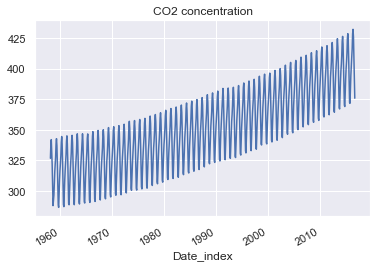

In [194]:
CO2.plot()
plt.title('CO2 concentration')
plt.show()

## (a) linear model

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 3.142e+04
Date:                Sat, 24 Nov 2018   Prob (F-statistic):               0.00
Time:                        16:53:31   Log-Likelihood:                -1925.7
No. Observations:                 698   AIC:                             3855.
Df Residuals:                     696   BIC:                             3864.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        307.6219      0.289   1063.749      0.0

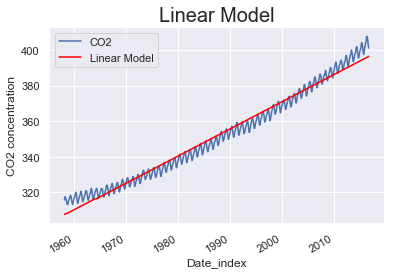

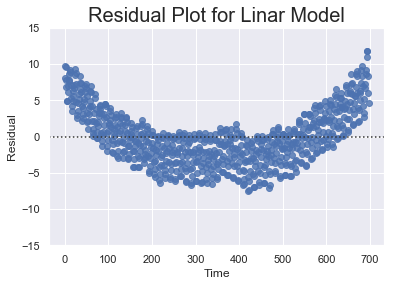

In [149]:
X = np.array(range(len(CO2)))
X = sm.add_constant(X)
model = sm.OLS(CO2,X)
res = model.fit()
print(res.summary())
#Plot Linear
plt.figure()
CO2.plot(label = 'CO2')
plt.plot(CO2.index,res.predict(X), label = 'Linear Model', color='red')
plt.title('Linear Model',fontsize=20)
plt.ylabel('CO2 concentration')
plt.legend()
plt.show()
#Plot Residual
plt.figure()
sns.residplot(X[:,1],CO2)
plt.title('Residual Plot for Linar Model', fontsize = 20)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.ylim((-15,15))
plt.show()

## quadratic model

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.774e+04
Date:                Sat, 24 Nov 2018   Prob (F-statistic):               0.00
Time:                        16:56:47   Log-Likelihood:                -1542.5
No. Observations:                 698   AIC:                             3091.
Df Residuals:                     695   BIC:                             3105.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        314.5630      0.250   1257.017      0.0

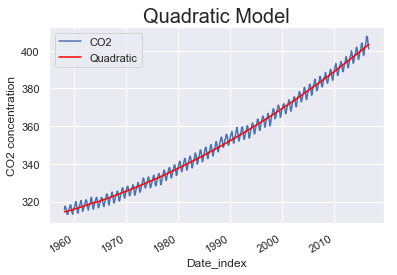

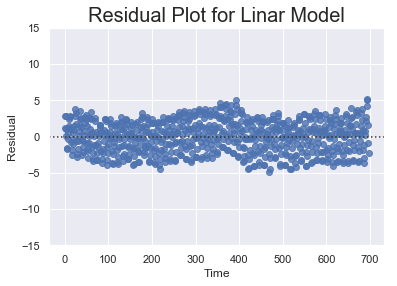

In [151]:
X = np.array(range(len(CO2)))
X = sm.add_constant(X)
X2 = pd.DataFrame(X)
X2[2]=X2[1].apply(lambda x:x**2)
X2 = np.array(X2)
model = sm.OLS(CO2,X2)
res_2 = model.fit()
print(res_2.summary())
#Plot 2_order model
plt.figure()
CO2.plot(label="CO2")
plt.plot(CO2.index,res_2.predict(X2),label='Quadratic', color='red')
plt.title('Quadratic Model',fontsize=20)
plt.ylabel('CO2 concentration')
plt.legend()
plt.show()
#Plot residuals
plt.figure()
sns.residplot(X[:,1],CO2, order = 2)
plt.title('Residual Plot for Linar Model', fontsize = 20)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.ylim((-15,15))
plt.show()

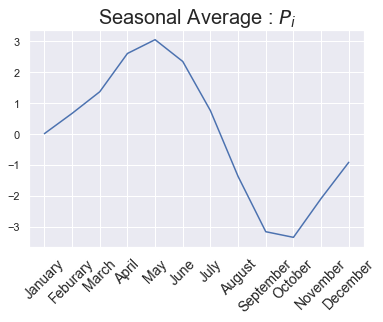

In [168]:
month_list = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 
              'August', 'September', 'October', 'November', 'December']

P_i = [residual[residual.index.month==i].mean() for i in range(1,13)]
plt.figure()
plt.plot(month_list,P_i)
plt.xticks(rotation=45, fontsize=14)
plt.title('Seasonal Average : $P_i$',fontsize=20)
plt.show()

In [180]:
CO2_deseason = pd.Series(CO2)

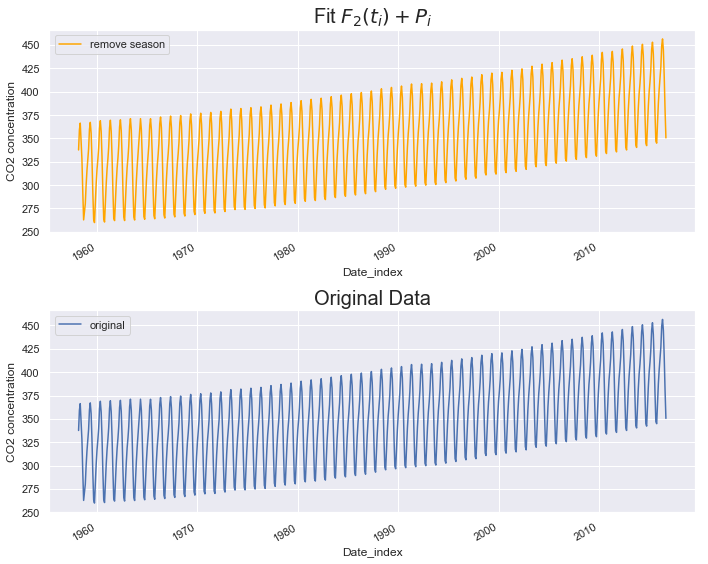

In [203]:
for index, num in CO2.iteritems():
    CO2_deseason[index]  = num + P_i[index.month-1]
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
CO2_deseason.plot(label='remove season', color='orange')
plt.title('Fit $F_2(t_i)+P_i$',fontsize=20)
plt.ylabel('CO2 concentration')
plt.legend()
plt.subplot(2,1,2)
CO2.plot(label='original')
plt.title('Original Data', fontsize=20)
plt.ylabel('CO2 concentration')
plt.legend()
plt.tight_layout()
plt.show()